In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import SVG 
import json
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import string
from collections import Counter
import operator
import sqlalchemy
import sqlite3 as sql
import pickle
import warnings
warnings.filterwarnings("ignore")

In [2]:
auburnDF = pd.read_csv("KevinTweets.csv")
alabamDF = pd.read_csv("alabamaftbl.csv")

In [11]:
def joinDF(df1, df2):
    joinedDF = pd.concat([df1, df2])
    return joinedDF

fullData = joinDF(auburnDF, alabamDF)

In [13]:
fullData.tail()

,Unnamed: 0,datetime,is_reply,is_retweet,nbr_favorite,nbr_reply,nbr_retweet,text,url,user_id,usernameTweet
1180,1180,2017-11-04 18:30:34,False,False,0,0,0,HELL YESSSSSSS!!!!!!!!!!! Great play boys!!! B...,/AUCouchCoach84/status/926864258956185603,907416154293055489,AUCouchCoach84
1181,1181,2016-04-15 21:59:56,False,False,0,0,0,A-Day is tomorrow. Who's going?\n\n#AlabamaFtb...,/Alabama_Ftbl/status/721080640821719044,719332920092135424,Alabama_Ftbl
1182,1182,2016-10-19 21:39:57,False,False,0,0,0,Jalen Hurts among eight Alabama players on mid...,/joe_och/status/788842141724381184,4526749708,joe_och
1183,1183,2017-11-11 22:20:42,False,False,0,0,0,# wareagle #auburnfootball #auburn #auvsuga...,/ashleymr0510/status/929458888713256960,334012457,ashleymr0510
1184,1184,2016-12-30 02:40:17,False,False,0,0,0,Gear up for the @CFAPeachBowl with official A...,/dotglenn3/status/814647261791711232,2566209180,dotglenn3


In [15]:
#Function for Analysis

def add_column_for_name(df, names_list, text_column):
    """
    Add column(s) that indicates whether name(s) is/are in text_column
    Args:
        df: pandas dataframe
        names_list: list of strings (names) 
        text_column: column containing text
    Returns:
        df with column of Booleans 
    """
    for name in names_list:
        df[name] = df['text'].apply(lambda tweet: word_in_text(name, tweet))
    return df


def remove_retweets(df, column, list_of_str):
    """
    Function to remove tweets that contain string in list_of_str
    """
    for string in list_of_str:
        df = df[df['text'].str.contains(string)==False]
    return df


def print_val_counts_for_True(df, list_of_cols):
    """
    Print number of Trues for columns in list_of_cols in dataframe df
    """
    for name in list_of_cols:
        print(name, df[name].value_counts()[True])

        
def word_in_text(word, text):
    """
    Function to make text lower case and return True if a term is present,
    False otherwise
    """
    word = word.lower()
    text = text.lower()
    match = re.search(word, text)
    if match:
        return True
    return False


def lower_text(list_text):
    """
    Make text lowercase
    """
    new_list_text = []
    for word in list_text:
        new_word = word.lower() 
        new_list_text.append(new_word)
    return new_list_text


def extract_link(text):
    """
    Extract links from tweets
    """
    regex = r'https?://[^\s<>"]+|www\.[^\s<>"]+'
    match = re.search(regex, text)
    if match:
        return match.group()
    return ''

# Functions for tokenizing and preprocessing

def tokenize(s):
    return tokens_re.findall(s)


def preprocess(s, lowercase = False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens


def tweet_tokenize(text):
    """
    Tokenize text
    """
    tweet_tokens = preprocess(text, lowercase = False)
    return tweet_tokens


def itertools_flatten(list_of_list):
    """
    Flatten out list of lists
    """
    from itertools import chain
    return list(chain(*list_of_list))


def most_frequent(terms_all, names_list):
    """
    Returns most frequent terms, aside from stop words. terms_all is a list with all the terms
    """
    count_all = Counter()
    full_stop = stop + names_list
    interesting_terms = [term for term in terms_all if term not in full_stop]
    
    # Update the counter
    count_all.update(interesting_terms)
    return count_all.most_common(20)

def make_col_lowercase(df, list_of_cols):
    """
    Function to get lowercase of columns in list_of_cols
    Args:
        df: pandas dataframe
        list_of_cols: list of column names (string)
    """
    for string in list_of_cols:
        df['lower_'+ string] = df[string].apply(lambda tweet: lower_text(tweet))
    return df

In [40]:
#Now Start picking them one by one!!!!
listColumn = ["Auburn", "Alabama", "AuburnAlabama"]

newDF = add_column_for_name(df=fullData, names_list=listColumn, text_column='test')

In [41]:
print_val_counts_for_True(newDF, listColumn)

Auburn 4659
Alabama 1685
AuburnAlabama 3


In [42]:
uniqueTweetDF = newDF.drop_duplicates(subset='text')

In [43]:
uniqueTweetDF.shape, newDF.shape

((4971, 14), (6187, 14))

Delete tweets that are all retweets to create an Original Datasets DataFrame

In [44]:
listStr = ['RT', 'rt', ' RT ']
originalTweetDF = remove_retweets(uniqueTweetDF, 'text', listStr)

In [45]:
print("originalTweetDF has {} rows".format(originalTweetDF.shape[0]))

print_val_counts_for_True(originalTweetDF, listColumn)

originalTweetDF has 4287 rows
Auburn 3721
Alabama 678
AuburnAlabama 3


In [46]:
originalTweetDF = originalTweetDF.reset_index(drop = True)
originalTweetDF.head()

,Unnamed: 0,datetime,is_reply,is_retweet,nbr_favorite,nbr_reply,nbr_retweet,text,url,user_id,usernameTweet,Auburn,Alabama,AuburnAlabama
0,1,2017-08-25 02:26:56,False,False,3,0,3,Auburn University has asked fans not to roll t...,/AUFootball2017/status/900907315397873664,816450392720547841,AUFootball2017,True,False,False
1,2,2017-10-08 15:55:37,False,False,0,0,0,SULONEN: Silence speaks volumes for #Auburnfoo...,/dbbmonica/status/917055892125650944,2603224578,dbbmonica,True,False,False
2,3,2016-04-09 20:41:47,False,False,3,0,0,My horse all-in to first place #Jovon referen...,/AlKotero/status/718901745640837120,1437203700,AlKotero,True,False,False
3,4,2016-09-03 21:58:59,False,False,0,0,0,Best time of the year! #gameday #auburnfootba...,/bradcampbell29/status/772192190634295297,41000950,bradcampbell29,True,False,False
4,5,2017-09-16 22:37:29,False,False,1,0,0,"Gus Malzahn era: 2013-September 16, 2017. #RIP...",/harrison_helton/status/909184492803420160,705528705116971009,harrison_helton,True,False,False


In [47]:
originalTweetDF['justAuburn'] = np.where((originalTweetDF['Auburn']==True) & (originalTweetDF['AuburnAlabama']== False), True, False)

originalTweetDF['justAlabama'] = np.where((originalTweetDF['Alabama'] == True) & (originalTweetDF['AuburnAlabama'] == False), True, False)

In [48]:
originalTweetDF['link'] = originalTweetDF['text'].apply(extract_link)

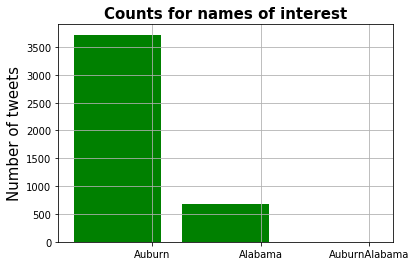

In [49]:
names = ["Auburn", "Alabama", "AuburnAlabama"]
tweets_by_name = [originalTweetDF['Auburn'].value_counts()[True], originalTweetDF['Alabama'].value_counts()[True], 
                  originalTweetDF['AuburnAlabama'].value_counts()[True]]
x_pos = list(range(len(names)))
width = 0.8
fig, ax = plt.subplots()
plt.bar(x_pos, tweets_by_name, width, alpha=1, color='g')
ax.set_ylabel('Number of tweets', fontsize=15)
ax.set_title('Counts for names of interest', fontsize=15, fontweight='bold')
ax.set_xticks([p + 0.4 * width for p in x_pos])
ax.set_xticklabels(names)
plt.grid()
plt.savefig('tweet_by_name_1', format='png')

PREPROCESSING STEP

In [50]:
# For pre-processing emoticons, @-mentions, hash-tags, URLs

emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]

# re.compile compiles a regex pattern into a regex object that can be used for match or search

tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)

In [51]:
originalTweetDF['tweet_tokens'] = originalTweetDF['text'].apply(lambda tweet: tweet_tokenize(tweet))

In [52]:
originalTweetDF.tweet_tokens.head()

0    [Auburn, University, has, asked, fans, not, to...
1    [SULONEN, :, Silence, speaks, volumes, for, #A...
2    [My, horse, all-in, to, first, place, #Jovon, ...
3    [Best, time, of, the, year, !, #gameday, #aubu...
4    [Gus, Malzahn, era, :, 2013, -, September, 16,...
Name: tweet_tokens, dtype: object

In [53]:
originalTweetDF.head()

,Unnamed: 0,datetime,is_reply,is_retweet,nbr_favorite,nbr_reply,nbr_retweet,text,url,user_id,usernameTweet,Auburn,Alabama,AuburnAlabama,justAuburn,justAlabama,link,tweet_tokens
0,1,2017-08-25 02:26:56,False,False,3,0,3,Auburn University has asked fans not to roll t...,/AUFootball2017/status/900907315397873664,816450392720547841,AUFootball2017,True,False,False,True,False,,"[Auburn, University, has, asked, fans, not, to..."
1,2,2017-10-08 15:55:37,False,False,0,0,0,SULONEN: Silence speaks volumes for #Auburnfoo...,/dbbmonica/status/917055892125650944,2603224578,dbbmonica,True,False,False,True,False,,"[SULONEN, :, Silence, speaks, volumes, for, #A..."
2,3,2016-04-09 20:41:47,False,False,3,0,0,My horse all-in to first place #Jovon referen...,/AlKotero/status/718901745640837120,1437203700,AlKotero,True,False,False,True,False,,"[My, horse, all-in, to, first, place, #Jovon, ..."
3,4,2016-09-03 21:58:59,False,False,0,0,0,Best time of the year! #gameday #auburnfootba...,/bradcampbell29/status/772192190634295297,41000950,bradcampbell29,True,False,False,True,False,https://www.,"[Best, time, of, the, year, !, #gameday, #aubu..."
4,5,2017-09-16 22:37:29,False,False,1,0,0,"Gus Malzahn era: 2013-September 16, 2017. #RIP...",/harrison_helton/status/909184492803420160,705528705116971009,harrison_helton,True,False,False,True,False,,"[Gus, Malzahn, era, :, 2013, -, September, 16,..."


In [54]:
originalTweetDF['AlabamaToken'] = np.where((originalTweetDF['justAlabama'] ==True), originalTweetDF['tweet_tokens'], '')

originalTweetDF['AuburnToken'] = np.where((originalTweetDF['justAuburn'] ==True), originalTweetDF['tweet_tokens'], '')

In [55]:
originalTweetDF.head()

,Unnamed: 0,datetime,is_reply,is_retweet,nbr_favorite,nbr_reply,nbr_retweet,text,url,user_id,usernameTweet,Auburn,Alabama,AuburnAlabama,justAuburn,justAlabama,link,tweet_tokens,AlabamaToken,AuburnToken
0,1,2017-08-25 02:26:56,False,False,3,0,3,Auburn University has asked fans not to roll t...,/AUFootball2017/status/900907315397873664,816450392720547841,AUFootball2017,True,False,False,True,False,,"[Auburn, University, has, asked, fans, not, to...",,"[Auburn, University, has, asked, fans, not, to..."
1,2,2017-10-08 15:55:37,False,False,0,0,0,SULONEN: Silence speaks volumes for #Auburnfoo...,/dbbmonica/status/917055892125650944,2603224578,dbbmonica,True,False,False,True,False,,"[SULONEN, :, Silence, speaks, volumes, for, #A...",,"[SULONEN, :, Silence, speaks, volumes, for, #A..."
2,3,2016-04-09 20:41:47,False,False,3,0,0,My horse all-in to first place #Jovon referen...,/AlKotero/status/718901745640837120,1437203700,AlKotero,True,False,False,True,False,,"[My, horse, all-in, to, first, place, #Jovon, ...",,"[My, horse, all-in, to, first, place, #Jovon, ..."
3,4,2016-09-03 21:58:59,False,False,0,0,0,Best time of the year! #gameday #auburnfootba...,/bradcampbell29/status/772192190634295297,41000950,bradcampbell29,True,False,False,True,False,https://www.,"[Best, time, of, the, year, !, #gameday, #aubu...",,"[Best, time, of, the, year, !, #gameday, #aubu..."
4,5,2017-09-16 22:37:29,False,False,1,0,0,"Gus Malzahn era: 2013-September 16, 2017. #RIP...",/harrison_helton/status/909184492803420160,705528705116971009,harrison_helton,True,False,False,True,False,,"[Gus, Malzahn, era, :, 2013, -, September, 16,...",,"[Gus, Malzahn, era, :, 2013, -, September, 16,..."


In [56]:
auburnTok = originalTweetDF['AuburnToken'].values.tolist()
alabamTok = originalTweetDF['AlabamaToken'].values.tolist()

auburnList = itertools_flatten(auburnTok)
alabamaList = itertools_flatten(alabamTok)

auburnListLo = [x.lower() for x in auburnList]
alabamaListLo = [x.lower() for x in alabamaList]

In [57]:
listCol = ["tweet_tokens", "AlabamaToken", "AuburnToken"]
originalTweetDF = make_col_lowercase(originalTweetDF, listCol)

In [58]:
originalTweetDF.head()

,Unnamed: 0,datetime,is_reply,is_retweet,nbr_favorite,nbr_reply,nbr_retweet,text,url,user_id,...,AuburnAlabama,justAuburn,justAlabama,link,tweet_tokens,AlabamaToken,AuburnToken,lower_tweet_tokens,lower_AlabamaToken,lower_AuburnToken
0,1,2017-08-25 02:26:56,False,False,3,0,3,Auburn University has asked fans not to roll t...,/AUFootball2017/status/900907315397873664,816450392720547841,...,False,True,False,,"[Auburn, University, has, asked, fans, not, to...",,"[Auburn, University, has, asked, fans, not, to...","[auburn, university, has, asked, fans, not, to...",[],"[auburn, university, has, asked, fans, not, to..."
1,2,2017-10-08 15:55:37,False,False,0,0,0,SULONEN: Silence speaks volumes for #Auburnfoo...,/dbbmonica/status/917055892125650944,2603224578,...,False,True,False,,"[SULONEN, :, Silence, speaks, volumes, for, #A...",,"[SULONEN, :, Silence, speaks, volumes, for, #A...","[sulonen, :, silence, speaks, volumes, for, #a...",[],"[sulonen, :, silence, speaks, volumes, for, #a..."
2,3,2016-04-09 20:41:47,False,False,3,0,0,My horse all-in to first place #Jovon referen...,/AlKotero/status/718901745640837120,1437203700,...,False,True,False,,"[My, horse, all-in, to, first, place, #Jovon, ...",,"[My, horse, all-in, to, first, place, #Jovon, ...","[my, horse, all-in, to, first, place, #jovon, ...",[],"[my, horse, all-in, to, first, place, #jovon, ..."
3,4,2016-09-03 21:58:59,False,False,0,0,0,Best time of the year! #gameday #auburnfootba...,/bradcampbell29/status/772192190634295297,41000950,...,False,True,False,https://www.,"[Best, time, of, the, year, !, #gameday, #aubu...",,"[Best, time, of, the, year, !, #gameday, #aubu...","[best, time, of, the, year, !, #gameday, #aubu...",[],"[best, time, of, the, year, !, #gameday, #aubu..."
4,5,2017-09-16 22:37:29,False,False,1,0,0,"Gus Malzahn era: 2013-September 16, 2017. #RIP...",/harrison_helton/status/909184492803420160,705528705116971009,...,False,True,False,,"[Gus, Malzahn, era, :, 2013, -, September, 16,...",,"[Gus, Malzahn, era, :, 2013, -, September, 16,...","[gus, malzahn, era, :, 2013, -, september, 16,...",[],"[gus, malzahn, era, :, 2013, -, september, 16,..."


In [63]:
#USe NLTK download stopwords  #nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\babatunde\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [64]:
# string.punctuation gives string of ASCI chars which are considered punctuation chars 
punctuation = list(string.punctuation)
more_punctuation = ["’", "‘"]

# A custom list of stopwords
more_stops = ["el", "don't", "it's", "get", "via", "rt", "de", "would", "make", "i'm", "2", 
              "he's", "one", "says","amp", "say", "us", "u"]

# The full stop list contains English stopwords, as well as my custom list of stopwords and punctuation to remove
stop = stopwords.words('english') + punctuation + more_punctuation + more_stops

In [65]:
auburnList = ['auburn', 'auburnfootball']
alabamaList= ['alabama', 'alabamaftbl']

In [75]:
mostAuburn = most_frequent(auburnListLo, auburnList)

mostAlabama = most_frequent(alabamaListLo, alabamaList)

In [89]:
#Send to pickle
originalTweetDF.to_pickle("orginalTweetDF.pickle")